# Определение стоимости автомобилей
___
# Determining the cost of cars

В одном из сервисов по продаже автомобилей происходит разработка приложения, нацеленного на привлечение клиентов. 
В данном приложении возможно узнать рыночную стоимость своего автомобился.
Имеются исторические данные, включающие в себя технические характеристики, цены.
Необходимо построить модель, которая позволит определить стоимость автомобился.

Важно обратить внимание на:

- качество предсказания;
- скорость предсказания;
- время обучения.
___
One of the car sales services is developing an application aimed at attracting customers.
In this application, it is possible to find out the market value of your car.
Historical data is available, including technical specifications, prices.
It is necessary to build a model that will allow you to determine the cost of the car.

It is important to pay attention to:

- quality of prediction;
- prediction speed;
- studying time.


## Подготовка данных
___
## Data preparation

In [60]:
pip install lightgbm

ERROR:root:Cannot parse: 1:4: pip install lightgbm
Traceback (most recent call last):
  File "C:\Users\kiril\anaconda3\lib\site-packages\lab_black.py", line 218, in format_cell
    formatted_code = _format_code(cell)
  File "C:\Users\kiril\anaconda3\lib\site-packages\lab_black.py", line 29, in _format_code
    return format_str(src_contents=code, mode=FileMode())
  File "C:\Users\kiril\anaconda3\lib\site-packages\black.py", line 725, in format_str
    src_node = lib2to3_parse(src_contents.lstrip(), mode.target_versions)
  File "C:\Users\kiril\anaconda3\lib\site-packages\black.py", line 836, in lib2to3_parse
    raise exc from None
black.InvalidInput: Cannot parse: 1:4: pip install lightgbm


Note: you may need to restart the kernel to use updated packages.


In [61]:
pip install nb_black

ERROR:root:Cannot parse: 1:4: pip install nb_black
Traceback (most recent call last):
  File "C:\Users\kiril\anaconda3\lib\site-packages\lab_black.py", line 218, in format_cell
    formatted_code = _format_code(cell)
  File "C:\Users\kiril\anaconda3\lib\site-packages\lab_black.py", line 29, in _format_code
    return format_str(src_contents=code, mode=FileMode())
  File "C:\Users\kiril\anaconda3\lib\site-packages\black.py", line 725, in format_str
    src_node = lib2to3_parse(src_contents.lstrip(), mode.target_versions)
  File "C:\Users\kiril\anaconda3\lib\site-packages\black.py", line 836, in lib2to3_parse
    raise exc from None
black.InvalidInput: Cannot parse: 1:4: pip install nb_black


In [62]:
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [63]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder

<IPython.core.display.Javascript object>

In [64]:
data = pd.read_csv("autos.csv")

<IPython.core.display.Javascript object>

In [65]:
data.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<IPython.core.display.Javascript object>

In [66]:
data.columns = [x.lower() for x in data.columns]

<IPython.core.display.Javascript object>

Объективно маловажные признаки: **datecrawled, registrationmonth, datecreated, numberofpictures, postalcode, lastseen**. Они не играют никакой роли в ценообразовании, являются лишь показателями, связанными с пользователями, которые их выкладывают. Можно смело избавиться от вышеназванных столбцов и продолжить исследование датасета.
___
Objectively unimportant features: **datecrawled, registrationmonth, datecreated, numberofpictures, postalcode, lastseen**. They do not play any role in pricing, they are only indicators associated with the users who post them. You can safely get rid of the above columns and continue exploring the dataset.

In [67]:
data = data.drop(
    columns=[
        "datecrawled",
        "registrationmonth",
        "datecreated",
        "numberofpictures",
        "postalcode",
        "lastseen",
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   price             354369 non-null  int64 
 1   vehicletype       316879 non-null  object
 2   registrationyear  354369 non-null  int64 
 3   gearbox           334536 non-null  object
 4   power             354369 non-null  int64 
 5   model             334664 non-null  object
 6   kilometer         354369 non-null  int64 
 7   fueltype          321474 non-null  object
 8   brand             354369 non-null  object
 9   repaired          283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


<IPython.core.display.Javascript object>

In [69]:
data.duplicated().sum()

45040

<IPython.core.display.Javascript object>

Избавляемся от дубликатов.
___
Getting rid of duplicates.

In [70]:
data = data.drop_duplicates().sort_index(ascending=True)

<IPython.core.display.Javascript object>

Исследуем датасет на предмет NaN.
___
We examine the dataset for NaN.

In [71]:
data.isna().mean()*100

price                0.000000
vehicletype         11.172247
registrationyear     0.000000
gearbox              5.562686
power                0.000000
model                5.935751
kilometer            0.000000
fueltype             9.945398
brand                0.000000
repaired            20.870335
dtype: float64

<IPython.core.display.Javascript object>

Процент пропусков велик, их необходимо заполнить.
___
The percentage of gaps is high, they must be filled.

In [72]:
data = data.fillna("unknown").copy()

<IPython.core.display.Javascript object>

<AxesSubplot:>

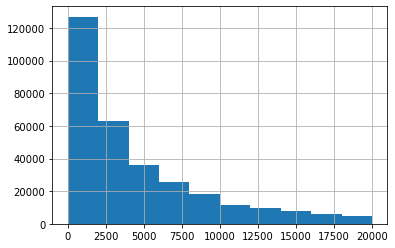

<IPython.core.display.Javascript object>

In [73]:
data["price"].hist()

In [74]:
data.loc[data["price"] <= 100].count()

price               12220
vehicletype         12220
registrationyear    12220
gearbox             12220
power               12220
model               12220
kilometer           12220
fueltype            12220
brand               12220
repaired            12220
dtype: int64

<IPython.core.display.Javascript object>

In [75]:
data.loc[data["price"] <= 10].count()

price               10122
vehicletype         10122
registrationyear    10122
gearbox             10122
power               10122
model               10122
kilometer           10122
fueltype            10122
brand               10122
repaired            10122
dtype: int64

<IPython.core.display.Javascript object>

In [76]:
data = data.loc[data["price"] >= 10]

<IPython.core.display.Javascript object>

In [77]:
data.head(5)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


<IPython.core.display.Javascript object>

In [78]:
data = data.loc[(data["power"] >= 50) & (data["power"] <= 400)]

<IPython.core.display.Javascript object>

In [79]:
data = data.loc[(data["registrationyear"] >= 1965) & (data["registrationyear"] <= 2016)]

<IPython.core.display.Javascript object>

Преобразуем данные в числовой вид.
___
Let's convert the data to numeric form.

Отдельный датасет для линейной регрессии.
___
Separate dataset for linear regression.

In [80]:
data_ohe = pd.get_dummies(data, drop_first=True)

<IPython.core.display.Javascript object>

Другой датасет для древовидных систем.
___
Another dataset for tree systems.

In [81]:
encoder = OrdinalEncoder()

<IPython.core.display.Javascript object>

In [82]:
ordinal_columns = [
    "vehicletype",
    "gearbox",
    "model",
    "fueltype",
    "brand",
    "repaired",
]

data_ord = data.copy()

data_ord[ordinal_columns] = encoder.fit_transform(data_ord[ordinal_columns])

<IPython.core.display.Javascript object>

Предобработка завершена, удалены дубликаты и пропуски. Присутпаем к обучению моделей.
___
Pre-processing completed, duplicates and omissions removed. We are present for training models.

## Обучение моделей
___
## Model training

Разделим датасет на признаки и таргеты.
___
Let's divide the dataset into features and targets.

**Для линейной регрессии**
___
**For linear regression**

In [83]:
target_ohe = data_ohe["price"]
features_ohe = data_ohe.drop("price", axis=1)

<IPython.core.display.Javascript object>

In [84]:
(
    features_train_ohe,
    features_test_ohe,
    target_train_ohe,
    target_test_ohe,
) = train_test_split(features_ohe, target_ohe, test_size=0.4, random_state=12345)

(
    features_test_ohe,
    features_valid_ohe,
    target_test_ohe,
    target_valid_ohe,
) = train_test_split(
    features_test_ohe, target_test_ohe, test_size=0.5, random_state=12345
)

<IPython.core.display.Javascript object>

Масштабируем показатели.
___
We scale indicators.

In [85]:
numeric = ["registrationyear", "power", "kilometer"]

scaler = StandardScaler()
scaler.fit(features_train_ohe[numeric])
features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_valid_ohe[numeric] = scaler.transform(features_valid_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])

C:\Users\kiril\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


<IPython.core.display.Javascript object>

**Для древовидных решений**
___
**For tree solutions**

In [86]:
target_ord = data_ord["price"]
features_ord = data_ord.drop("price", axis=1)

<IPython.core.display.Javascript object>

In [87]:
(
    features_train_ord,
    features_test_ord,
    target_train_ord,
    target_test_ord,
) = train_test_split(features_ord, target_ord, test_size=0.4, random_state=12345)

(
    features_test_ord,
    features_valid_ord,
    target_test_ord,
    target_valid_ord,
) = train_test_split(
    features_test_ord, target_test_ord, test_size=0.5, random_state=12345
)

<IPython.core.display.Javascript object>

Создадим модели и подберем методом **GridSearch**
___
Create models and select using the **GridSearch** method

In [88]:
def rmse(X, y):
    return math.sqrt(mse(X, y))

<IPython.core.display.Javascript object>

In [89]:
rmse = make_scorer(rmse, greater_is_better=False)

<IPython.core.display.Javascript object>

**Дерево решений**
___
**Decision Tree**


In [90]:
STATE = 12345

<IPython.core.display.Javascript object>

In [91]:
params_dtr = {"max_depth": range(1, 6)}

model_dtr = DecisionTreeRegressor(random_state=STATE)

grid_dtr = GridSearchCV(
    model_dtr, param_grid=params_dtr, cv=5, scoring=rmse, refit=True
)
grid_dtr.fit(features_train_ord, target_train_ord)
params_dtr = grid_dtr.best_params_
grid_dtr_best = DecisionTreeRegressor(**params_dtr, random_state=STATE)
grid_dtr_best

DecisionTreeRegressor(max_depth=5, random_state=12345)

<IPython.core.display.Javascript object>

**Случайный лес**
___
**Random Forest**

In [92]:
params_rfr = {"max_depth": range(1, 20, 5)}

model_rfr = RandomForestRegressor(random_state=STATE)

grid_rfr = GridSearchCV(model_rfr, params_rfr, cv=3, n_jobs=-1, verbose=2, scoring=rmse)
grid_rfr.fit(features_train_ord, target_train_ord)
params_rfr = grid_rfr.best_params_
grid_rfr_best = RandomForestRegressor(**params_rfr, random_state=STATE)
grid_rfr_best

Fitting 3 folds for each of 4 candidates, totalling 12 fits


RandomForestRegressor(max_depth=16, random_state=12345)

<IPython.core.display.Javascript object>

**Линейная регрессия**
___
**Random Forest**

In [93]:
model_lr = LinearRegression()
parameters = {"fit_intercept": [True, False], "normalize": [True, False]}
grid_lr = GridSearchCV(model_lr, param_grid=parameters, cv=5, scoring=rmse, refit=True)
grid_lr.fit(features_train_ohe, target_train_ohe)
params_lr = grid_lr.best_params_
grid_lr_best = LinearRegression(**params_lr)
grid_lr_best

LinearRegression()

<IPython.core.display.Javascript object>

**Градиентный бустинг**
___
**Gradient boosting**

In [94]:
parameters = {
    "max_depth": [15, 25, 35],
    "learning_rate": [0.01, 0.05, 0.15],
}
model_lgb = lgb.LGBMRegressor()
grid_lgb = GridSearchCV(model_lgb, param_grid=parameters, scoring=rmse, cv=3)
grid_lgb.fit(features_train_ohe, target_train_ohe)
params_lgb = grid_lgb.best_params_
grid_lgb_best = lgb.LGBMRegressor(**params_lgb)
grid_lgb_best

LGBMRegressor(learning_rate=0.15, max_depth=15)

<IPython.core.display.Javascript object>

## Анализ моделей
___
## Analysis of models

Прведем замеры времени обучения и предсказания.
___
Let's take measurements of training and prediction time.

**Дерево решения**
___
**Decision Tree**

In [95]:
%time grid_dtr_best.fit(features_train_ord, target_train_ord)
%time predicted_valid_dtr = grid_dtr_best.predict(features_valid_ord)

Wall time: 226 ms
Wall time: 14.1 ms


<IPython.core.display.Javascript object>

In [96]:
print("RMSE модели DTR:", math.sqrt(mse(target_valid_ord, predicted_valid_dtr)))

RMSE модели DTR: 2437.0630508688632


<IPython.core.display.Javascript object>

**Случайный лес**
___
**Random Forest**

In [97]:
%time grid_rfr_best.fit(features_train_ord, target_train_ord)
%time predicted_valid_rfr = grid_rfr_best.predict(features_valid_ord)

Wall time: 33.7 s
Wall time: 1.37 s


<IPython.core.display.Javascript object>

In [98]:
print("RMSE модели RFR:", math.sqrt(mse(target_valid_ord, predicted_valid_rfr)))

RMSE модели RFR: 1670.9583167824987


<IPython.core.display.Javascript object>

**Линейная регрессия**
___
**Linear regression**

In [99]:
%time grid_lr_best.fit(features_train_ord, target_train_ord)
%time predicted_valid_lr = grid_lr_best.predict(features_valid_ord)

Wall time: 50.1 ms
Wall time: 7 ms


<IPython.core.display.Javascript object>

In [100]:
print("RMSE модели LR:", math.sqrt(mse(target_valid_ord, predicted_valid_lr)))

RMSE модели LR: 2903.4149309065833


<IPython.core.display.Javascript object>

**lightgbm**

In [101]:
%time grid_lgb_best.fit(features_train_ohe, target_train_ohe)
%time predicted_valid_lgb = grid_lgb_best.predict(features_valid_ohe)

Wall time: 1.32 s
Wall time: 222 ms


<IPython.core.display.Javascript object>

In [102]:
print("RMSE модели LGB:", math.sqrt(mse(target_valid_ohe, predicted_valid_lgb)))

RMSE модели LGB: 1653.9804003077002


<IPython.core.display.Javascript object>

In [103]:
table = [
    [
        math.sqrt(mse(target_valid_ord, predicted_valid_dtr)),
        math.sqrt(mse(target_valid_ord, predicted_valid_rfr)),
        math.sqrt(mse(target_valid_ord, predicted_valid_lr)),
        math.sqrt(mse(target_valid_ohe, predicted_valid_lgb)),
    ],
    ["211 ms", "28.9 s", "35.5 ms", "38,9 s"],
    ["4.99 ms", "1,06 s", "3,29 ms", "597 ms"],
]
columns = ["dtr", "rfr", "lr", "lgb"]
index = ["RMSE", "fit_time", "predict_time"]
table_1 = pd.DataFrame(table, index, columns)
display(table_1)

,dtr,rfr,lr,lgb
RMSE,2437.063051,1670.958317,2903.414931,1653.9804
fit_time,211 ms,28.9 s,35.5 ms,"38,9 s"
predict_time,4.99 ms,"1,06 s","3,29 ms",597 ms


<IPython.core.display.Javascript object>

Как видно из таблицы, метод, показывающий наиболее подходящие значения RMSE - **LGB**. Второй после него - **RFR**, который, обладает в несколько меньшим временем обучения, однако меньшими значениями RMSE.
___
As can be seen from the table, the method showing the most appropriate RMSE values is **LGB**. The second after it is **RFR**, which has a slightly shorter training time, but lower RMSE values.

## Тестирование моделей
___
## Model testing

**lightgbm**

In [104]:
predicted_test_lgb = grid_lgb_best.predict(features_test_ohe)
print("RMSE модели LGB:", math.sqrt(mse(target_test_ohe, predicted_test_lgb)))

RMSE модели LGB: 1624.8282002676174


<IPython.core.display.Javascript object>

**Случайный лес**
___
**Random Forest**

In [105]:
predicted_test_rfr = grid_rfr_best.predict(features_test_ord)
print("RMSE модели LGB:", math.sqrt(mse(target_test_ord, predicted_test_rfr)))

RMSE модели LGB: 1646.9020908309935


<IPython.core.display.Javascript object>

In [106]:
table_1 = [
    [
        math.sqrt(mse(target_test_ord, predicted_test_rfr)),
        math.sqrt(mse(target_test_ohe, predicted_test_lgb)),
    ]
]
columns = ["rfr", "lgb"]
index = ["RMSE"]
table_2 = pd.DataFrame(table_1, index, columns)
display(table_2)

,rfr,lgb
RMSE,1646.902091,1624.8282


<IPython.core.display.Javascript object>

**Вывод:**

Промежуточные выводы подтвердились на тестовой выборке.

Несмотря на несильно отличающиеся значения **RMSE**, использование **LGB** намного выгоднее в аспекте результата.  

Основываясь на описанных заказчиком критериях: 
- качество предсказания;
- время обучения модели;
- время предсказания модели;

рекомендован **LGB**.
___
**Conclusion:**

Intermediate conclusions were confirmed on the test sample.

Despite slightly different **RMSE** values, using **LGB** is much more beneficial in terms of results.

Based on the criteria described by the customer:
- quality of prediction;
- model training time;
- model prediction time;

recommended by **LGB**.